In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import statsmodels.api as st

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

### Import the Data

# Warum fehlen 24 Werte bei temperature und 118 bei stores closed that day?

In [2]:
start_date_f = "2021-09-30"
start_date_p = "2021-10-01"
end_date = "2023-11-08"

# Create a boolean mask based on the date range
dates = lambda df : (df.index >= start_date_f) & (df.index <= end_date)
dates_p = lambda df : (df.index >= start_date_p) & (df.index <= end_date)

In [3]:
# Target variable (stationary)
passengers_df = pd.read_csv("passengers_stationary.csv").set_index("datetime")
passengers_df.index = pd.to_datetime(passengers_df.index, format = "ISO8601")

passengers = passengers_df[["total"]].dropna()

# Features
features = pd.read_csv("features.csv").set_index("Unnamed: 0")
features.rename_axis('datetime', inplace = True)
features.index = pd.to_datetime(features.index, format = "ISO8601")

# Relevant events & days
binary = pd.read_csv("data/merged_features-2.csv").set_index("Date")

# Set index to DateTime
binary.index = pd.to_datetime(binary.index, format = "ISO8601")

# Restrict to relevant dates
passengers = passengers[dates_p(passengers)]
features = features[dates(features)]
binary = binary[dates(binary)]

# Drop uneccessary columns
binary.drop(columns = ['bhfs_north', 'bhfs_middle', 'bhfs_south','PPP', 'Retail', 'Traffic', 'Guests',
                    'Population', "Sunshine"], inplace = True)

# Why temperature na?
# Add temperature as non-binary features
temp = binary["temperature"]
binary.drop(columns = "temperature", inplace = True)

In [4]:
binary.isna().sum()

Public Holiday ZH             0
School Holidays ZH            0
Public Holiday SH             0
School Holidays SH            0
Public Holiday TG             0
School Holidays TG            0
Public Holiday SG             0
School Holidays SG            0
Public Holiday SZ             0
School Holidays SZ            0
Public Holiday ZG             0
School Holidays ZG            0
Public Holiday AG             0
School Holidays AG            0
clear-night                   0
cloudy                        0
fog                           0
partly-cloudy-day             0
partly-cloudy-night           0
rain                          0
snow                          0
wind                          0
Weekday_Friday                0
Weekday_Monday                0
Weekday_Saturday              0
Weekday_Sunday                0
Weekday_Thursday              0
Weekday_Tuesday               0
Weekday_Wednesday             0
stores_closed_on_that_day    98
dtype: int64

In [5]:
# Fillna (why is it na?)
binary.stores_closed_on_that_day = binary.stores_closed_on_that_day.fillna(0)

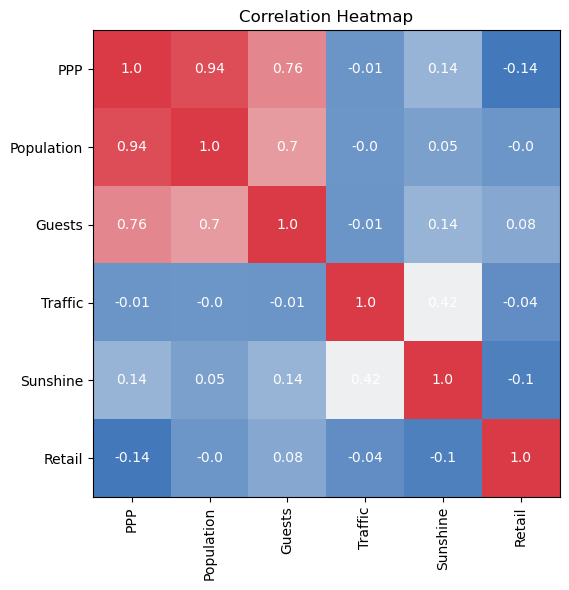

In [6]:
# Show correlation matrix
correlation_matrix = features[['PPP', 'Population', 'Guests', 'Traffic', 'Sunshine', 'Retail']].corr().round(2)


# Visualize the correlation in a heatmap and annotate

fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(correlation_matrix, cmap=sns.diverging_palette(250, 10, center="light",as_cmap=True))
ax.set_xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
ax.set_yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

# Loop over data dimensions and create text annotations.
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax.text(j, i, correlation_matrix.iloc[i, j],
                       ha="center", va="center", color="w")

# Set labels and title
ax.set_title('Correlation Heatmap')
fig.tight_layout()
plt.show()

# Data normalization

In [7]:
# Apply log to the non binary features as all were skewed (see Notebook XXX)
features = np.log(features)

# Apply same diff transformation to hourly data as to target
features["Traffic"] = features["Traffic"].diff(24)
features["Sunshine"] = features["Sunshine"].diff(24)
features = features.dropna()

# Concatenate features
features = pd.merge(features, binary, left_index = True, right_index = True, how = "left")

In [8]:
# Show duplicated
features[features.index.duplicated()] # This comes from the binary dataset. Why?

,PPP,Population,Guests,Traffic,Sunshine,Retail,Public Holiday ZH,School Holidays ZH,Public Holiday SH,School Holidays SH,...,snow,wind,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,stores_closed_on_that_day
2021-12-25 00:00:00,4.621044,12.987288,12.208285,0.577775,0.000000,4.765408,0.0,1.0,0.0,1.0,...,0.0,0.0,0,0,1,0,0,0,0,1.0
2021-12-25 01:00:00,4.621044,12.987288,12.208285,0.482128,-0.405465,4.765408,0.0,1.0,0.0,1.0,...,0.0,0.0,0,0,1,0,0,0,0,1.0
2021-12-25 02:00:00,4.621044,12.987288,12.208285,0.150479,0.000000,4.765408,0.0,1.0,0.0,1.0,...,0.0,0.0,0,0,1,0,0,0,0,1.0
2021-12-25 03:00:00,4.621044,12.987288,12.208285,-0.168551,0.000000,4.765408,0.0,1.0,0.0,1.0,...,0.0,0.0,0,0,1,0,0,0,0,1.0
2021-12-25 04:00:00,4.621044,12.987288,12.208285,-0.655667,0.000000,4.765408,0.0,1.0,0.0,1.0,...,0.0,0.0,0,0,1,0,0,0,0,1.0
2021-12-25 05:00:00,4.621044,12.987288,12.208285,-1.086728,0.405465,4.765408,0.0,1.0,0.0,1.0,...,0.0,0.0,0,0,1,0,0,0,0,1.0
2021-12-25 06:00:00,4.621044,12.987288,12.208285,-1.148291,0.000000,4.765408,0.0,1.0,0.0,1.0,...,0.0,0.0,0,0,1,0,0,0,0,1.0
2021-12-25 07:00:00,4.621044,12.987288,12.208285,-1.485258,0.000000,4.765408,0.0,1.0,0.0,1.0,...,0.0,0.0,0,0,1,0,0,0,0,1.0
2021-12-25 08:00:00,4.621044,12.987288,12.208285,-1.366204,0.309661,4.765408,0.0,1.0,0.0,1.0,...,0.0,0.0,0,0,1,0,0,0,0,1.0
2021-12-25 09:00:00,4.621044,12.987288,12.208285,-1.066451,-0.648443,4.765408,0.0,1.0,0.0,1.0,...,0.0,0.0,0,0,1,0,0,0,0,1.0


In [10]:
# Drop duplicates (WHY are here duplicates?!)
features = features[~features.index.duplicated(keep='first')]

In [13]:
# Die indices überlappen sich nicht überall. 4 rows fehlen bei passengers. Warum?
# Die indices überlappen sich nicht überall. 4 rows fehlen bei passengers. Warum?
# 26 und 27 März 2023 fehlt in features
# 23 und 24 November 2022, 22 Dezember 2022, und 29 und 30.8 fehlen in passengers

# Preliminary
passengers = passengers.resample("H").ffill()
features = features.resample("H").ffill()

In [17]:
# Split into training and test split
n_splits = 2
tscv = TimeSeriesSplit(n_splits)

y = passengers[["total"]].copy()
X = features.copy()

for train_index, test_index in tscv.split(passengers):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [18]:
# Standardize the Data to obtain better results
# Only standardize non binary data
non_binary = ['PPP', 'Population', 'Guests', 'Traffic', 'Sunshine', 'Retail']
X_train_nb = X_train[non_binary]
X_test_nb = X_test[non_binary]

# Standardize data
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_nb), columns = X_train_nb.columns).set_index(X_train_nb.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_nb), columns = X_test_nb.columns).set_index(X_test_nb.index)

# Concatenate with dummy variables
X_train_scaled = pd.merge(X_train_scaled, X_train[binary.columns], how = "left", left_index = True, right_index = True)
X_test_scaled = pd.merge(X_test_scaled, X_test[binary.columns], how = "left", left_index = True, right_index = True)

# Building the model

Use Lasso to find most important features

In [20]:
from sklearn.linear_model import LassoCV

In [23]:
# Use TimeSeriesSplit for cross-validation
tscv_cv = TimeSeriesSplit(n_splits=3) 

# Apply LassoCV
lasso_cv = LassoCV(alphas=np.logspace(-3, 3, 200), cv=tscv_cv)
lasso_cv.fit(X_train_scaled, y_train.values.ravel())

# Display the selected alpha
print(f"Selected Alpha: {lasso_cv.alpha_: 0.5f}")

# Examine coefficents
coefficients_df = pd.DataFrame({"Coefficient": lasso_cv.coef_}, index = X_train_scaled.columns)
# Show relevant and irrelevant coffecients
zero_coefficents = coefficients_df[coefficients_df["Coefficient"] == 0]
non_zero_coefficents = coefficients_df[coefficients_df["Coefficient"] != 0]
print(f"Lasso dropped {zero_coefficents.shape[0]} coefficients")

Selected Alpha:  0.00187
Lasso dropped 20 coefficients


<Figure size 1000x600 with 0 Axes>

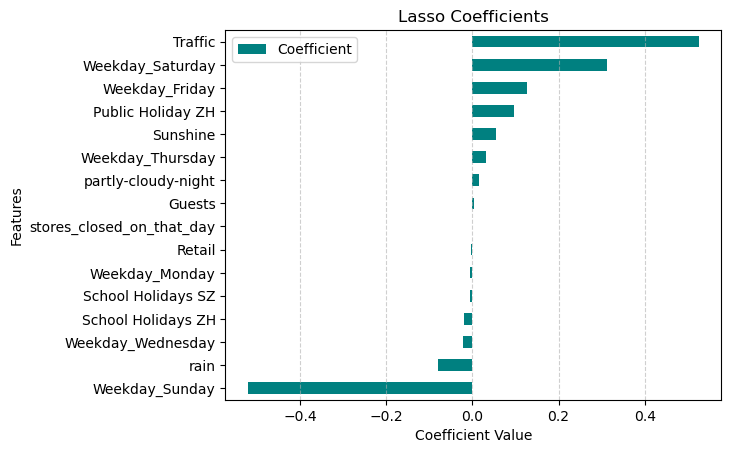

In [24]:
# ToDo: Different colors
# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
non_zero_coefficents.sort_values(by='Coefficient').plot.barh(color='teal')
plt.title('Lasso Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.6);

## ToD0: Make chart that shows how values converge

In [14]:
# Drop the zero coefficents
non_zero_coef = list(non_zero_coefficents.index)
X_train_scaled = X_train_scaled[non_zero_coef].copy()
X_test_scaled = X_test_scaled[non_zero_coef].copy()

## Training the LSTM

Did not use RNN because of vanishing gradient. SHould not forget what happened 10 hours before Also see correlogram

In [15]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2023-11-23 14:23:41.475338: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 14:23:41.478746: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 14:23:41.512795: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 14:23:41.512821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 14:23:41.513844: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [ ]:
### Potentials
# Add stateful
# Add lags
# Optimize
# Show improvement per batch
# Hyperparameter scaling
# Which loss and optimizer

In [16]:
batch_size = 1

lstm = Sequential()

# Add time steps?!
# Stateful wirklich true?
lstm.add(LSTM(units=50, input_shape=(X_train_scaled.shape[1],1)))
lstm.add(Dense(units=1, activation = "relu"))
# Welcher loss function?
lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Train the model
lstm.fit(X_train_scaled, y_train, epochs=1, batch_size=32)

# Evaluate model performance
scores = lstm.evaluate(X_train_scaled, y_train, batch_size=batch_size, verbose=0)

385/385 [==============================] - 6s 11ms/step - loss: 0.5420 - accuracy: 0.0028


## Optimize model

In [66]:
# Learning rate
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
# Can you use random search for Time Series
# Define the model-building function
def build_model(hp):
    
    model = keras.Sequential()
    model.add(LSTM(units=50, input_shape=(X_train_scaled.shape[1],1)))
    
    # Tune the number of Dense layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=256, step=32)))
        
    model.add(layers.Dropout(0.2))

    # Output layer
    model.add(layers.Dense(1, activation = "relu")) 

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error') 

    return model

# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective= 'val_loss',
    max_trials= 5, 
)

# Perform hyperparameter search
tuner.search(X_train_scaled, y_train,
             epochs=50,
             validation_split= 0.2) # What does that mean?

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Trial 5 Complete [00h 03m 21s]
val_loss: 0.2425478994846344

Best val_loss So Far: 0.2425478994846344
Total elapsed time: 00h 14m 05s


In [68]:
pred = best_model.predict(X_test_scaled)

192/192 [==============================] - 1s 4ms/step


## Haben wir wirklich kein DataLeakage drin?

## Making predictions

### Coole graphen zeigen. Plot of mse after each epoch; JEDEN INPUT VERSTEHEN!!!!!

In [69]:
# Generate predictions (not yet converted back to normal data)
def generate_prediction(X):
    # Chnage best model!
    predicted_scaled = pd.DataFrame(best_model.predict(X), index = X.index)
    predicted_scaled.columns = ["Prediction"]
    return predicted_scaled

In [70]:
# invert differenced value
def inverse_difference(yhat, history = passengers_df, interval=24):
    # Merge the logged actual data and the prediction
    x = pd.merge(history[["log"]], yhat, left_index = True, right_index = True)
    
    # Shift by the number of periods used to remove the seasonality
    x["Shifted"] = x.log.shift(interval)
    # Drop the 24 days for which no previous season available
    x = x.dropna()
    # Show to actual prediction by summing the prediction and the past seasonal value and reversing the log transformation
    x["pred"] = np.exp(x.Prediction+x.Shifted)
    # Show the actual data by reversing the log transformation
    x["actual"] = np.exp(x.log)
    return x

In [84]:
predicted_scaled = generate_prediction(X_test_scaled)

192/192 [==============================] - 1s 4ms/step


In [85]:
x = inverse_difference(predicted_scaled)

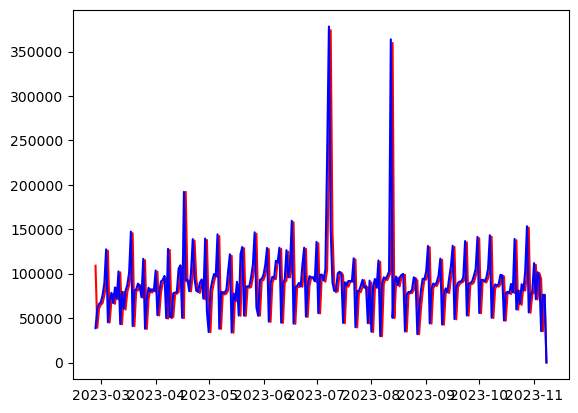

In [89]:
fig, ax = plt.subplots()
ax.plot(x.pred.resample("D").sum(), c="r")
ax.plot(x.actual.resample("D").sum(), c="blue")

In [ ]:
todo:
- All in one file. Danach files spliten
- Vorher testen ob keine Daten fehlen
- Beim Model wirklich alles verstehen. Was einzelne Parameter bedeuten
- Heute: 1 finales Model bauen mit predictions und graph, der verlauf zeigt
- Wochenende aufräumen und konsolidieren